### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle
import itertools
import matplotlib.pyplot as plt

### Data

In [3]:
experiment_name = 'PMG 284 monitoring'
products = 'known_products'

In [4]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_1000/all.csv',
                'Silane': '../data/silan/pmg166_3rdseries_full.csv',
                'PMG 247 monitoring': '../data/PMG_247/preprocessed_PMG247_monitoring.csv',
                'PMG 271 monitoring': '../data/PMG_271/PMG271_monitoring_druga_seria.csv',
                'PMG 284 monitoring': '../data/PMG_284/seria1.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture.csv'
                }

reagents_paths = {'Saccharose hydrolysis': ['../data/saccharose_1000/sucrose.csv', 
                                            '../data/saccharose_1000/glucose.csv',
                                            '../data/saccharose_1000/fructose.csv'],
                'Silane': [],
                'PMG 247 monitoring': ['../data/PMG_247/preprocessed_substrate0.csv',
                                      '../data/PMG_247/preprocessed_substrate1.csv'],
                'PMG 271 monitoring': ['../data/PMG_271/preprocessed_substrate0.csv',
                                      '../data/PMG_271/preprocessed_substrate1.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_substrate0.csv',
                                      '../data/PMG_284/preprocessed_substrate1.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_substrate0.csv',
                                       '../data/PMG_287/preprocessed_substrate1.csv',
                                       '../data/PMG_287/preprocessed_product.csv']}

mixture_separators = {'Saccharose hydrolysis': '\t',
                'Silane': '\t',
                'PMG 247 monitoring': ',',
                'PMG 271 monitoring': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

reagents_separators = {'Saccharose hydrolysis': '\t',
                'Silane': '\t',
                'PMG 247 monitoring': '\t',
                'PMG 271 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_1000/comparing_with_first/'+products+'/',
                'Silane': '../results/silan/comparing_with_first/'+products+'/',
                'PMG 247 monitoring': '../results/PMG_247/comparing_with_first/'+products+'/',
                'PMG 271 monitoring': '../results/PMG_271/comparing_with_first/'+products+'/',
                'PMG 284 monitoring': '../results/PMG_284/comparing_with_first/'+products+'/',
                'PMG 287 monitoring': '../results/PMG_287/comparing_with_first/'+products+'/'}

substances_names = {'Saccharose hydrolysis': ['saccharose', 'glucose', 'fructose'],
                    'Silane': [],
                    'PMG 247 monitoring': ['substrate_0', 'substrate_1'], #probably same as in PMG 271 but not sure
                    'PMG 271 monitoring': ['triethylsilane', '1-hexene'],
                    'PMG 284 monitoring': ['2-pentene', 'triethylsilane', 'products'],
                    'PMG 287 monitoring': ['1-hexene', 'triethylsilane', 'product']
                   }

integrals_to_compare_with = {'PMG 284 monitoring': '../data/PMG_284/284_calki_seria1.csv',
                    'PMG 287 monitoring': '../data/PMG_287/287_monitoring.xlsx'
                            }

### Finding all values of kappa, kappa_th

In [5]:
def convert(txt):
    k = float(txt)
    if k%1 ==0:
        return int(k)
    return k

In [6]:
all_kappas = []
all_kappas_th = []
for file in os.listdir(results_paths[experiment_name]):
    if file.startswith('noise_proportions_in_times'):
        kappa = convert(file.split('_')[4])
        all_kappas.append(kappa)
        kappa_th = convert(file.split('_')[5][:-4])
        all_kappas_th.append(kappa_th)
        
all_kappas = sorted(list(set(all_kappas)))
all_kappas_th = sorted(list(set(all_kappas_th)))

In [7]:
kappas_to_remove = [1.2, 0.75]
kappas_th_to_remove = [1.2, 0.75]

In [8]:
all_kappas = sorted(list(set(all_kappas) - set(kappas_to_remove)))
all_kappas_th = sorted(list(set(all_kappas_th) - set(kappas_th_to_remove)))

In [9]:
all_kappas

[0.1, 0.25, 0.5, 1, 1.05, 1.1, 1.15]


### Reading results for different values of kappa, kappa_th

In [10]:
results_dict = {}

for kappa in all_kappas:
    for kappa_th in all_kappas_th:
        try:
            with open(results_paths[experiment_name] + 'proportions_in_times_' +
                                  str(kappa)+'_'+str(kappa_th)+'.pkl', 'rb') as f:
                y = pickle.load(f)
                y = np.array(y)
                results_dict[(kappa, kappa_th)] = y
        except FileNotFoundError:
            results_dict[(kappa, kappa_th)] = None

### Setting time for particular experiments

In [11]:
time_range = {
                'Saccharose hydrolysis': list(range(1000)),
                'Silane': '',
                'PMG 247 monitoring': '',
                'PMG 271 monitoring': '',
                'PMG 284 monitoring': list(range(1,1000,10)),
                'PMG 287 monitoring': list(range(1,1000,10))
}

### Visualising results for different parameters, different components

In [12]:
component_nr = 1

In [13]:
lin_regr = False

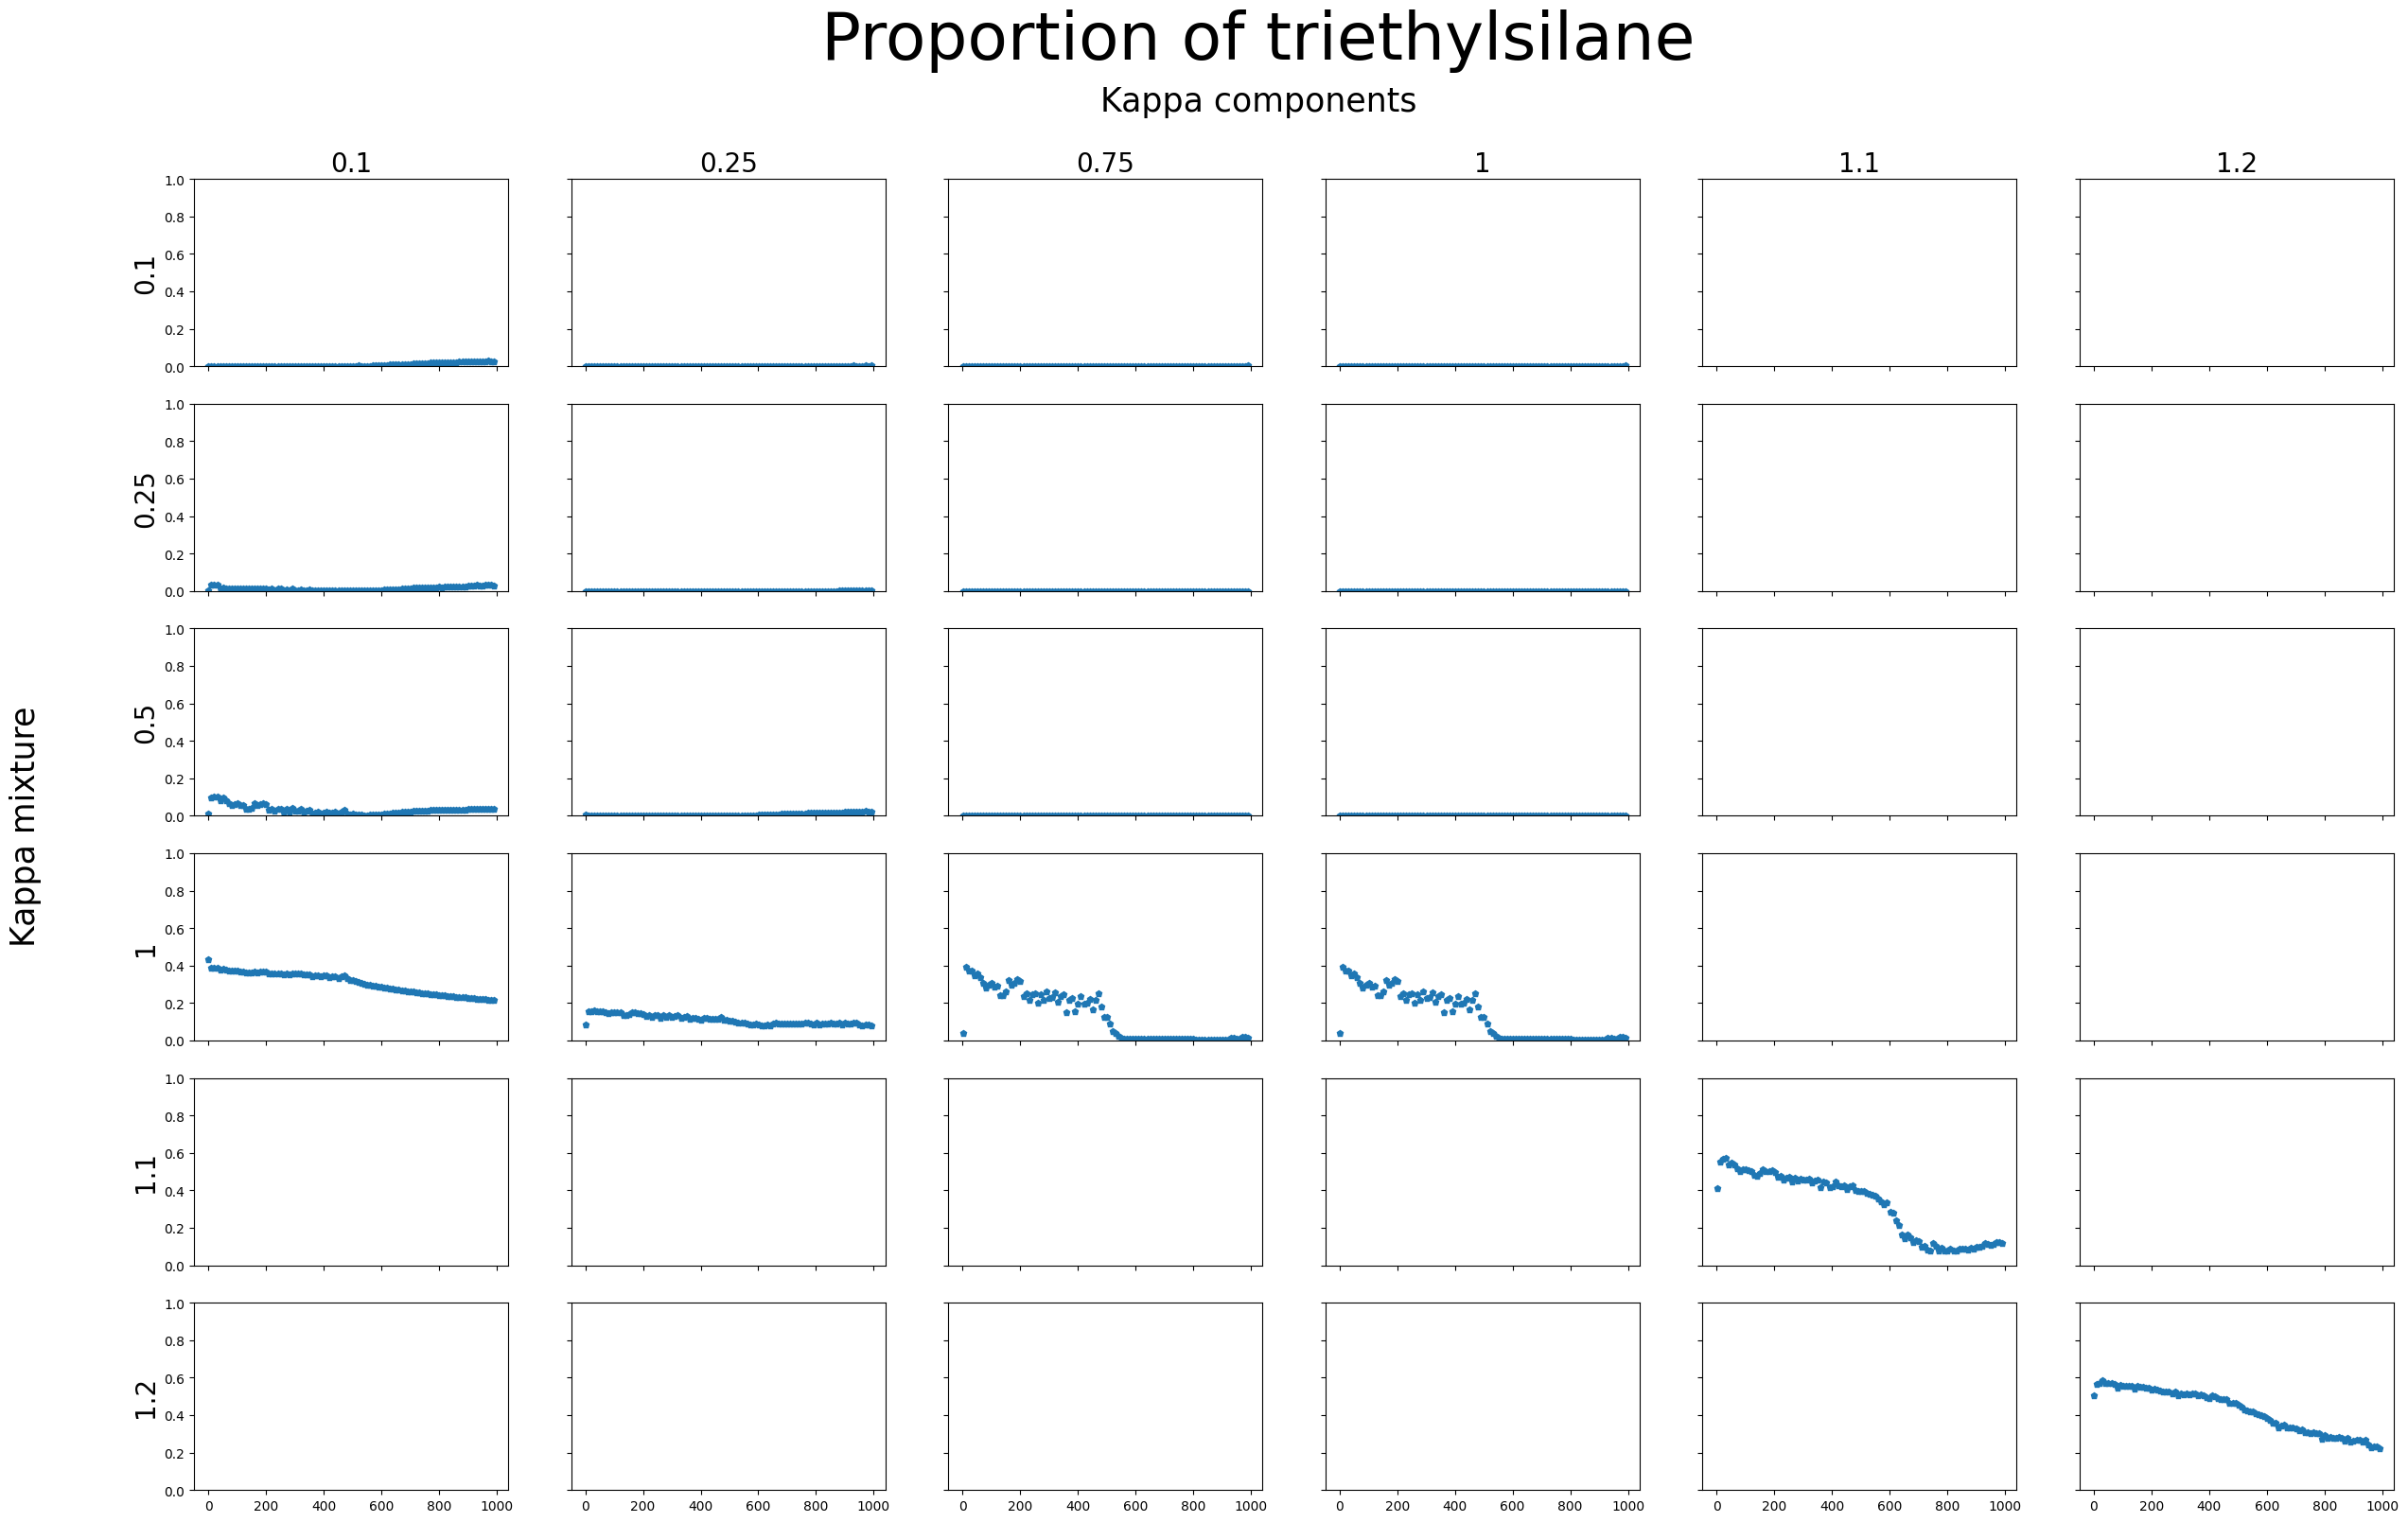

In [14]:
fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Proportion of ' + substances_names[experiment_name][component_nr], fontsize=50)
fig.set_size_inches(30, 18, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            y = results_dict[(kappa, kappa_th)][:, component_nr]
            axx.plot(time_range[experiment_name], y, 'p', markersize=5)
            if lin_regr:
                t = np.array(time_range[experiment_name])
                t_and_ones = np.vstack([t, np.ones(len(t))]).T
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                axx.plot(time_range[experiment_name], slope*t+intercept, linewidth=2.5)
        except TypeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
#fig.savefig(results_paths[experiment_name]+'comparison_for_different_kappas_'+ substances_names[experiment_name][component_nr]+'.png')

### Visualising results for different parameters, all components together

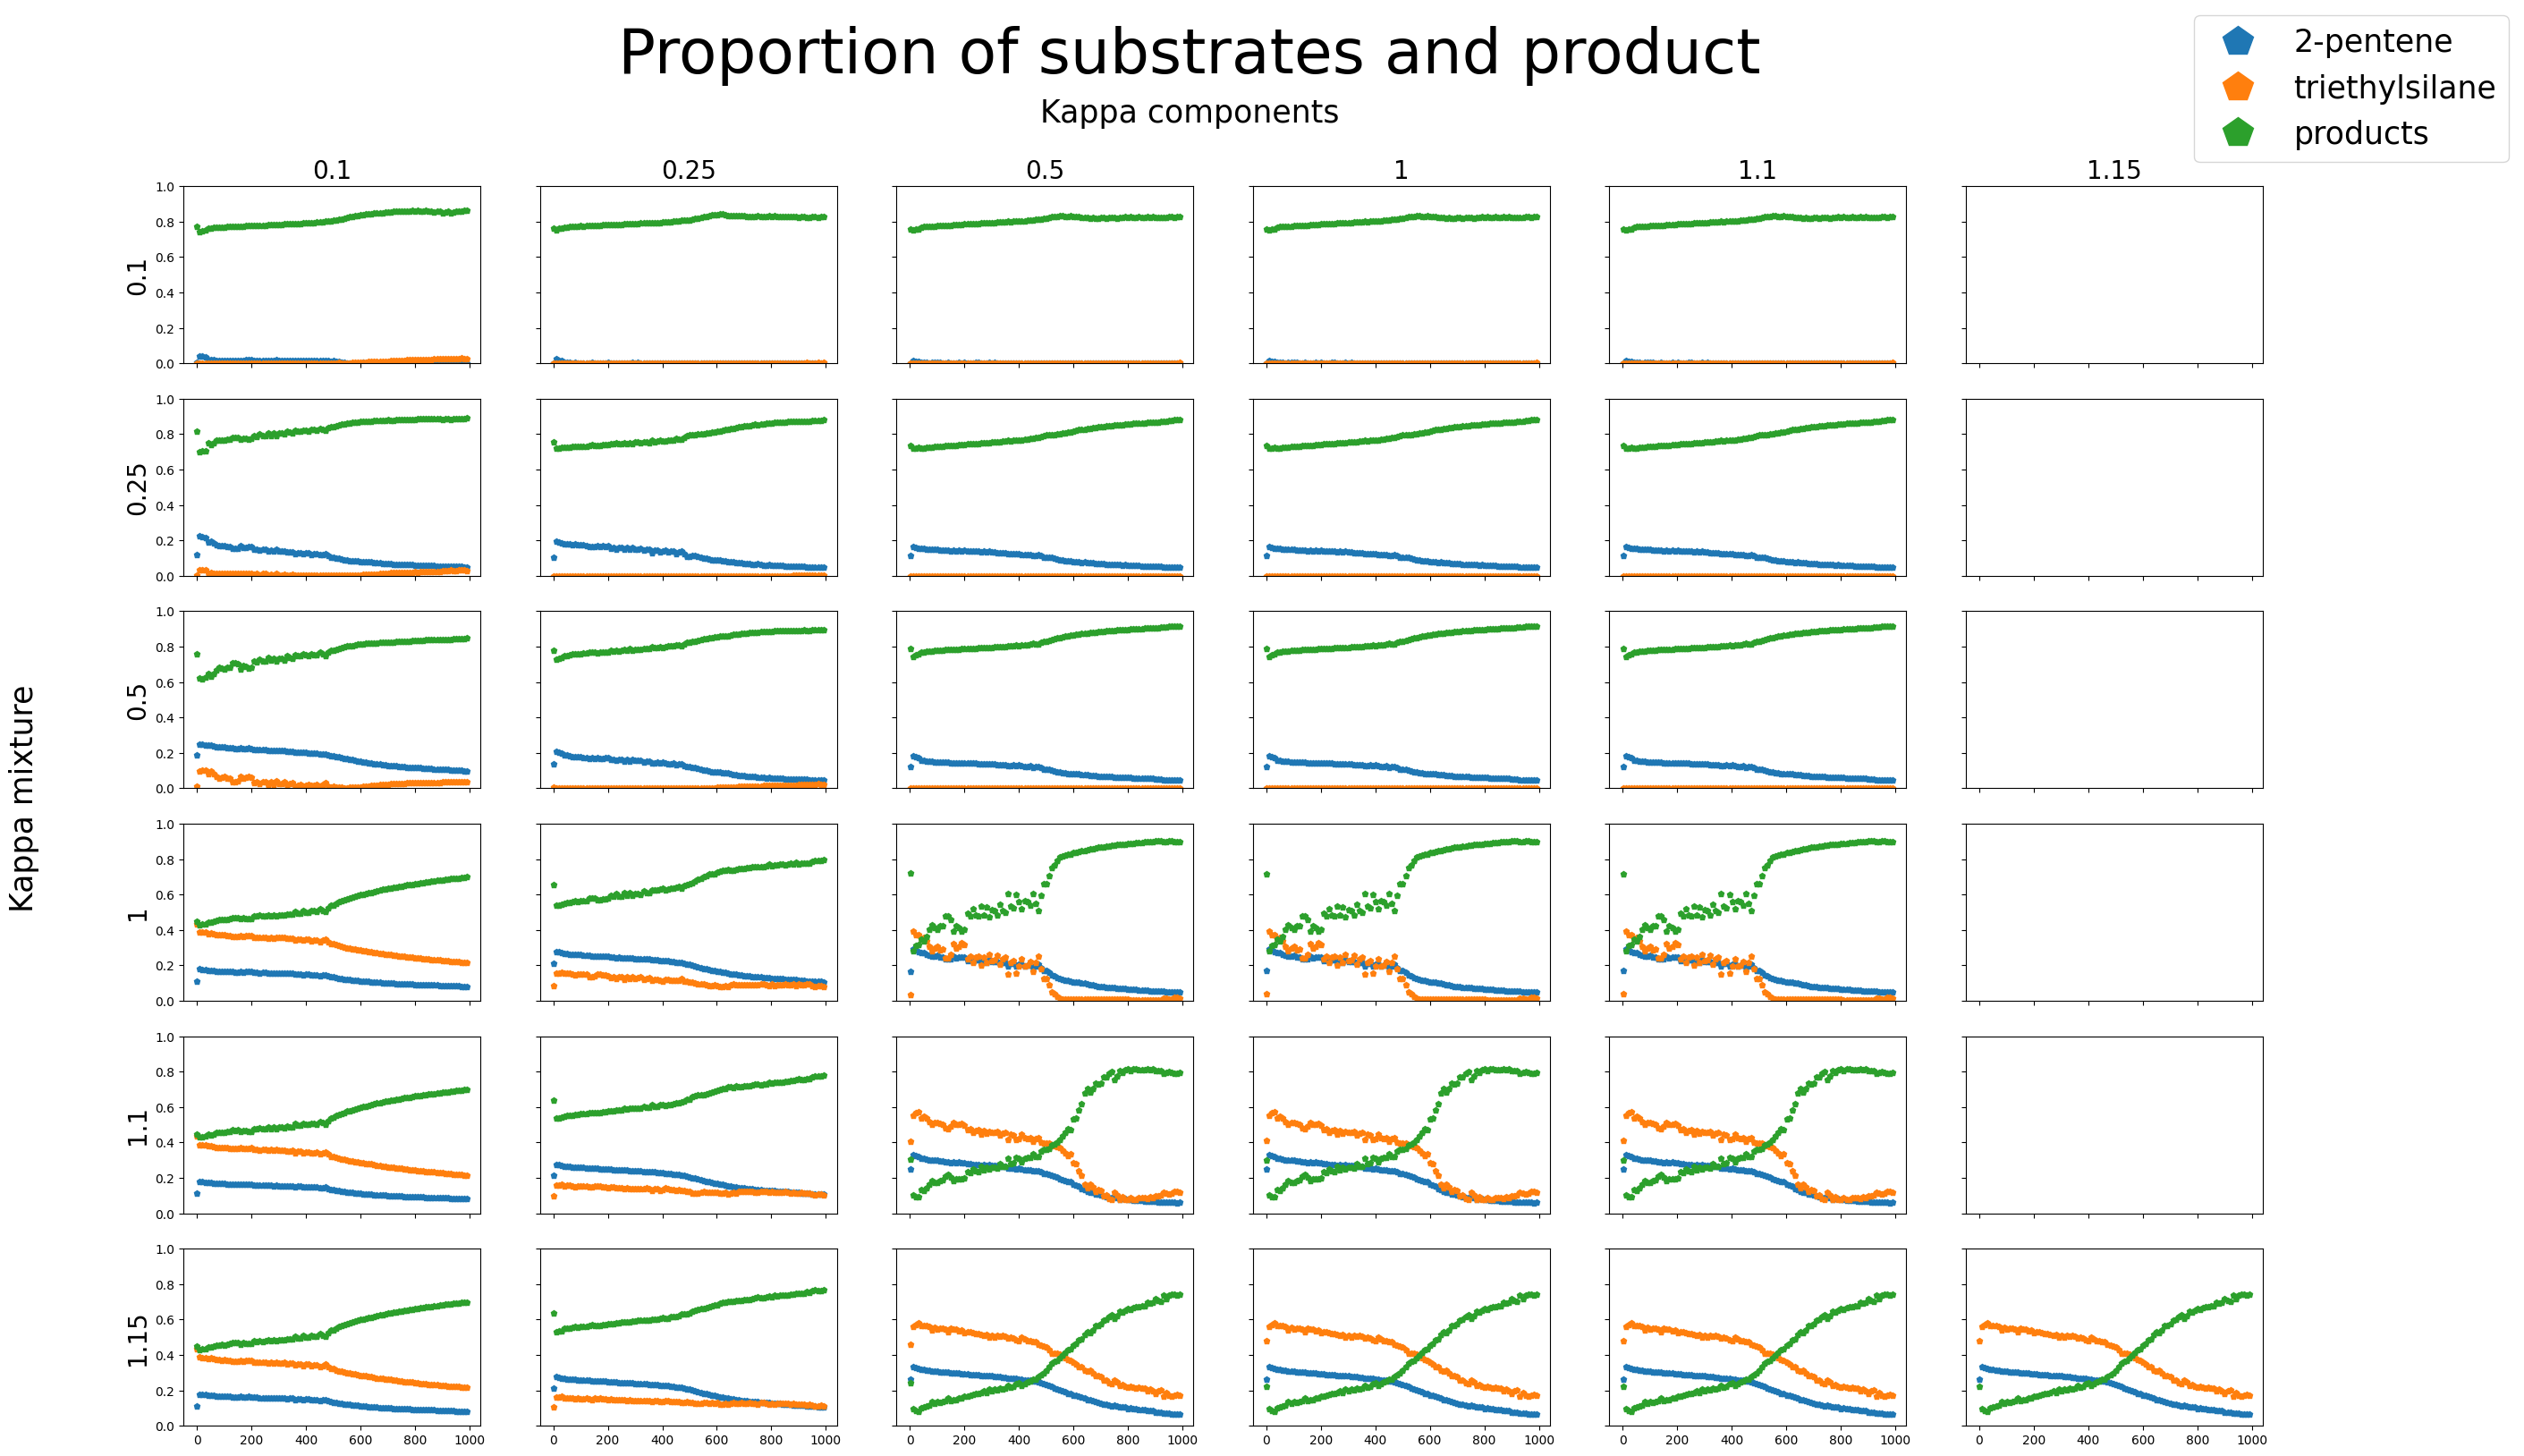

In [14]:
fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Proportion of substrates and product', fontsize=50)
fig.set_size_inches(30, 18, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            y = results_dict[(kappa, kappa_th)]
            for i in range(y.shape[1]):
                axx.plot(time_range[experiment_name], y[:,i], 'p', markersize=5, label=substances_names[experiment_name][i])
        except TypeError:
            axx.plot(0,0)
        except AttributeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', prop={'size': 25}, markerscale=5)
#fig.savefig(results_paths[experiment_name]+'comparison_for_different_kappas_components_separately.png')

### Visualising results for different parameters, all components together + integrals

In [12]:
if experiment_name == 'PMG 287 monitoring':
    integrals = pd.read_excel(integrals_to_compare_with[experiment_name])
    integrals_time = integrals.iloc[:,3]
    integrals_values = integrals.iloc[:,:3]
    integrals_values = integrals_values.iloc[:,[1,2,0]]
if experiment_name == 'PMG 284 monitoring':
    integrals = pd.read_csv(integrals_to_compare_with[experiment_name], sep=';')
    integrals['substrat'] = integrals.iloc[:,0].apply(lambda x: float(x.replace(',', '.')))
    integrals['product'] = integrals.iloc[:,1].apply(lambda x: float(x.replace(',', '.')))
    integrals.drop(integrals.columns[0:2], axis=1, inplace=True)
    integrals_time = integrals.iloc[:,0]
    integrals_values = integrals.iloc[:,1:]

In [13]:
integrals_values_normalized = integrals_values.div(integrals_values.sum(axis=1), axis=0)

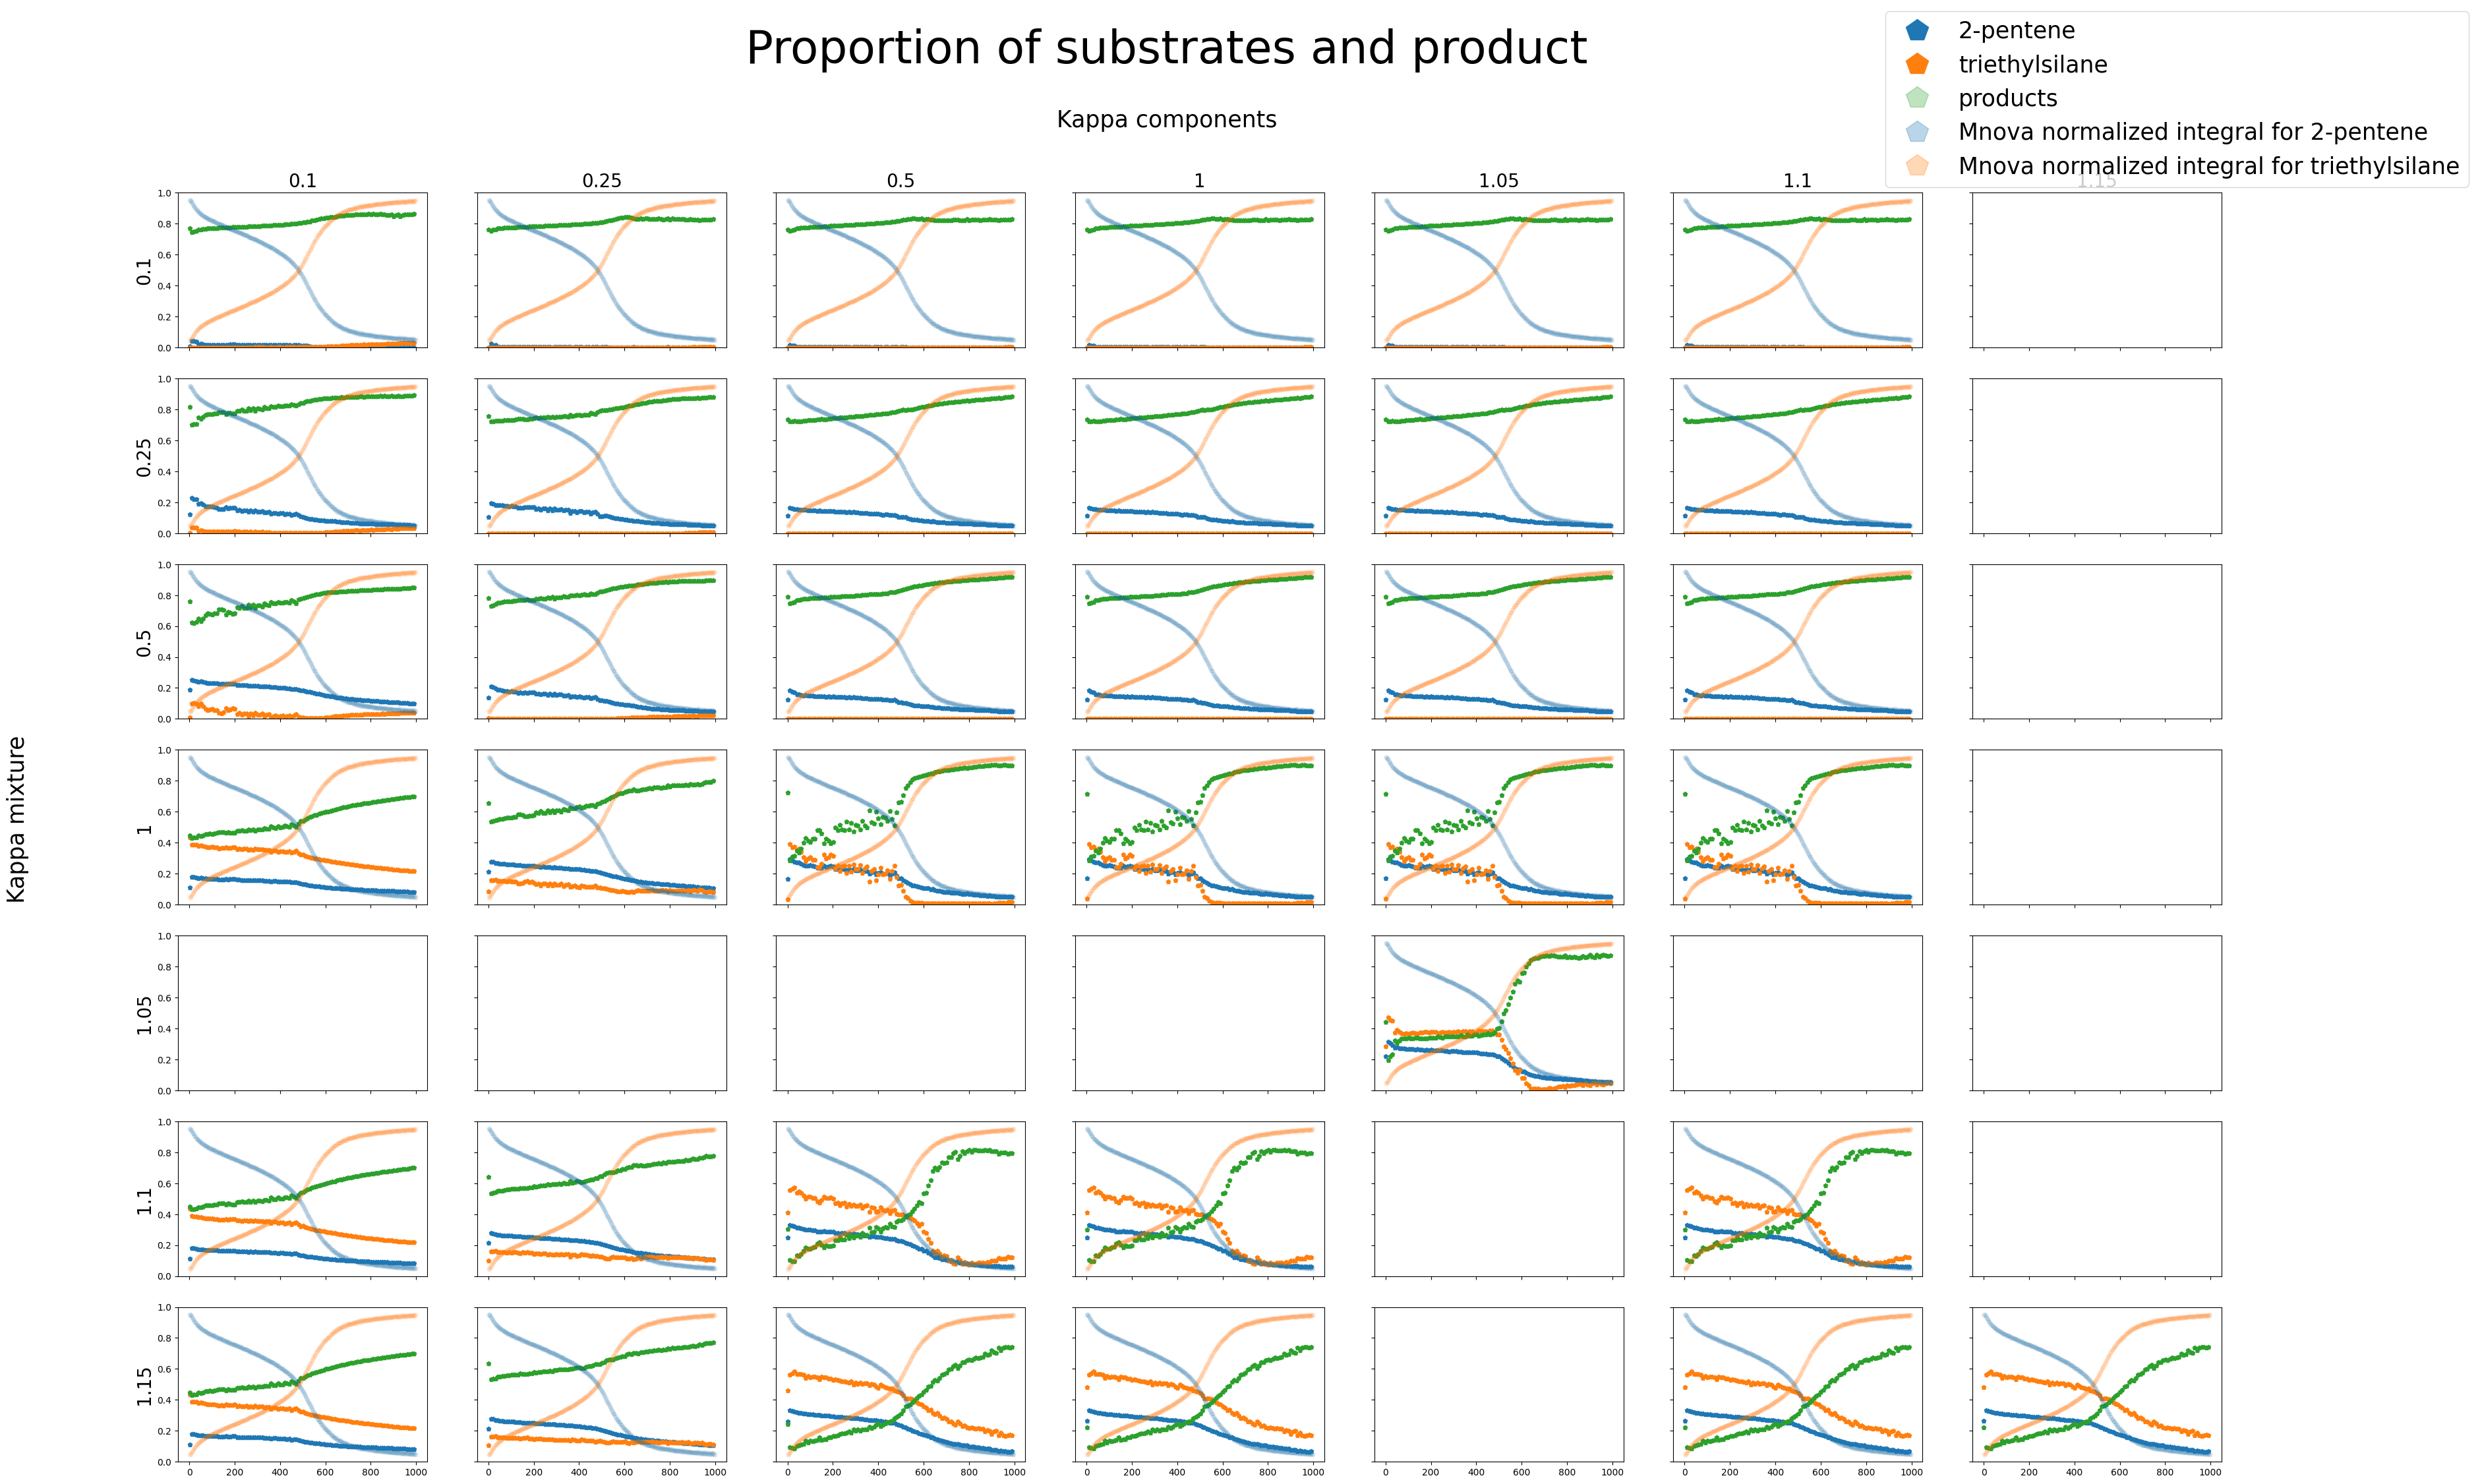

In [14]:
colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
             '#7f7f7f', '#bcbd22', '#17becf']

fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Proportion of substrates and product', fontsize=50)
fig.set_size_inches(40, 25, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            y = results_dict[(kappa, kappa_th)]
            for i in range(y.shape[1]):
                axx.plot(time_range[experiment_name], y[:,i], 'p', markersize=5, 
                         label=substances_names[experiment_name][i],
                        color = colors_list[i])
            for i in range(integrals_values_normalized.shape[1]):
                axx.plot([el/5 for el in integrals_time], integrals_values_normalized.iloc[:,i], 'p', 
                         markersize=5, label='Mnova normalized integral for ' + substances_names[experiment_name][i],
                         color = colors_list[i], alpha=0.03
                        )
        except TypeError:
            axx.plot(0,0)
        except AttributeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
handles, labels = ax.get_legend_handles_labels()

legend = fig.legend(handles, labels, loc='upper right', prop={'size': 25}, markerscale=5)

for lh in legend.legendHandles[i+1:]: 
    lh.set_alpha(0.3)

#fig.savefig(results_paths[experiment_name]+'comparison_for_different_kappas_components_separately_plus_integrals.png')

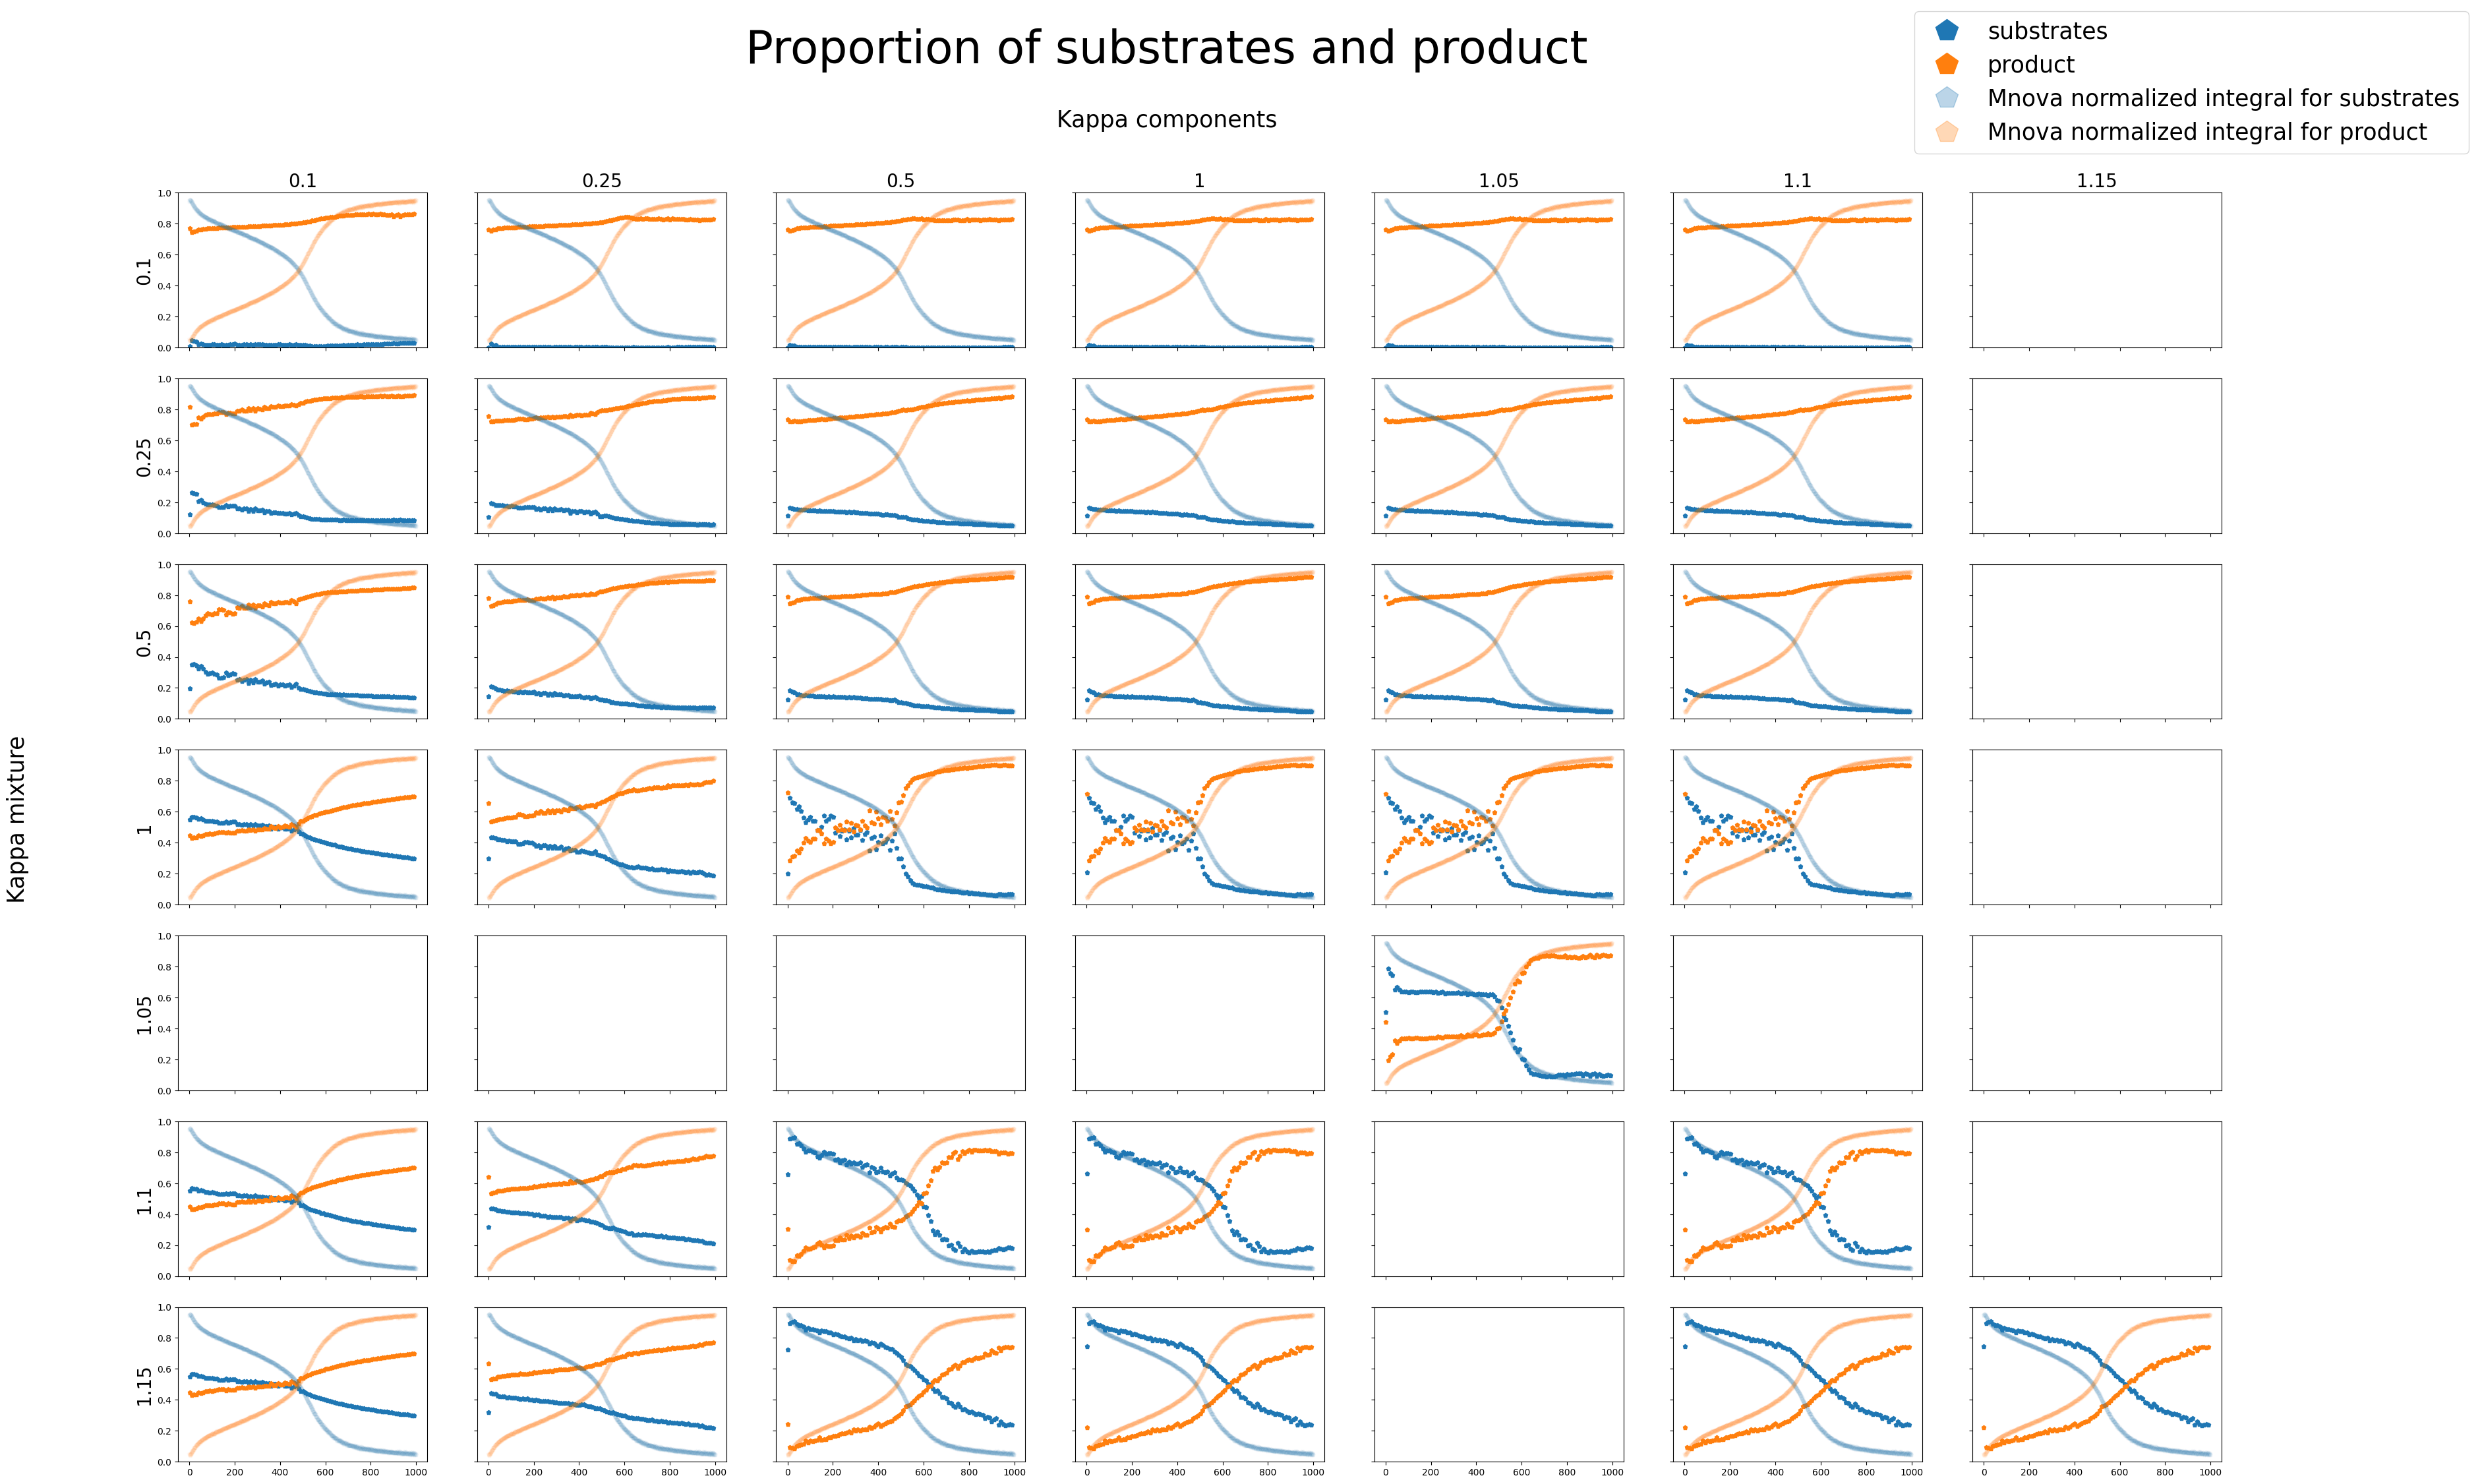

In [15]:
components_numbers = [0,1]
product_index = [2]

colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
             '#7f7f7f', '#bcbd22', '#17becf']

fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Proportion of substrates and product', fontsize=50)
fig.set_size_inches(40, 25, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            #components
            y = 0
            for nr in components_numbers:
                y = y + results_dict[(kappa, kappa_th)][:, nr]
            axx.plot(time_range[experiment_name], y, 'p', markersize=5,
                    label='substrates',
                        color = colors_list[0])
            #product
            y = results_dict[(kappa, kappa_th)]
            axx.plot(time_range[experiment_name], y[:,product_index], 'p', markersize=5, 
                         label='product',
                        color = colors_list[1])
            for i in range(integrals_values_normalized.shape[1]):
                axx.plot([el/5 for el in integrals_time], integrals_values_normalized.iloc[:,i], 'p', 
                         markersize=5, label='Mnova normalized integral for ' + ['substrates', 'product'][i],
                         color = colors_list[i], alpha=0.03
                        )
        except TypeError:
            axx.plot(0,0)
        except AttributeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
handles, labels = ax.get_legend_handles_labels()

legend = fig.legend(handles, labels, loc='upper right', prop={'size': 25}, markerscale=5)

for lh in legend.legendHandles[i+1:]: 
    lh.set_alpha(0.3)
#fig.savefig(results_paths[experiment_name]+'comparison_for_different_kappas_components_together_plus_integrals.png')

### Components together

In [20]:
components_numbers = [0, 1]
lin_regr = False

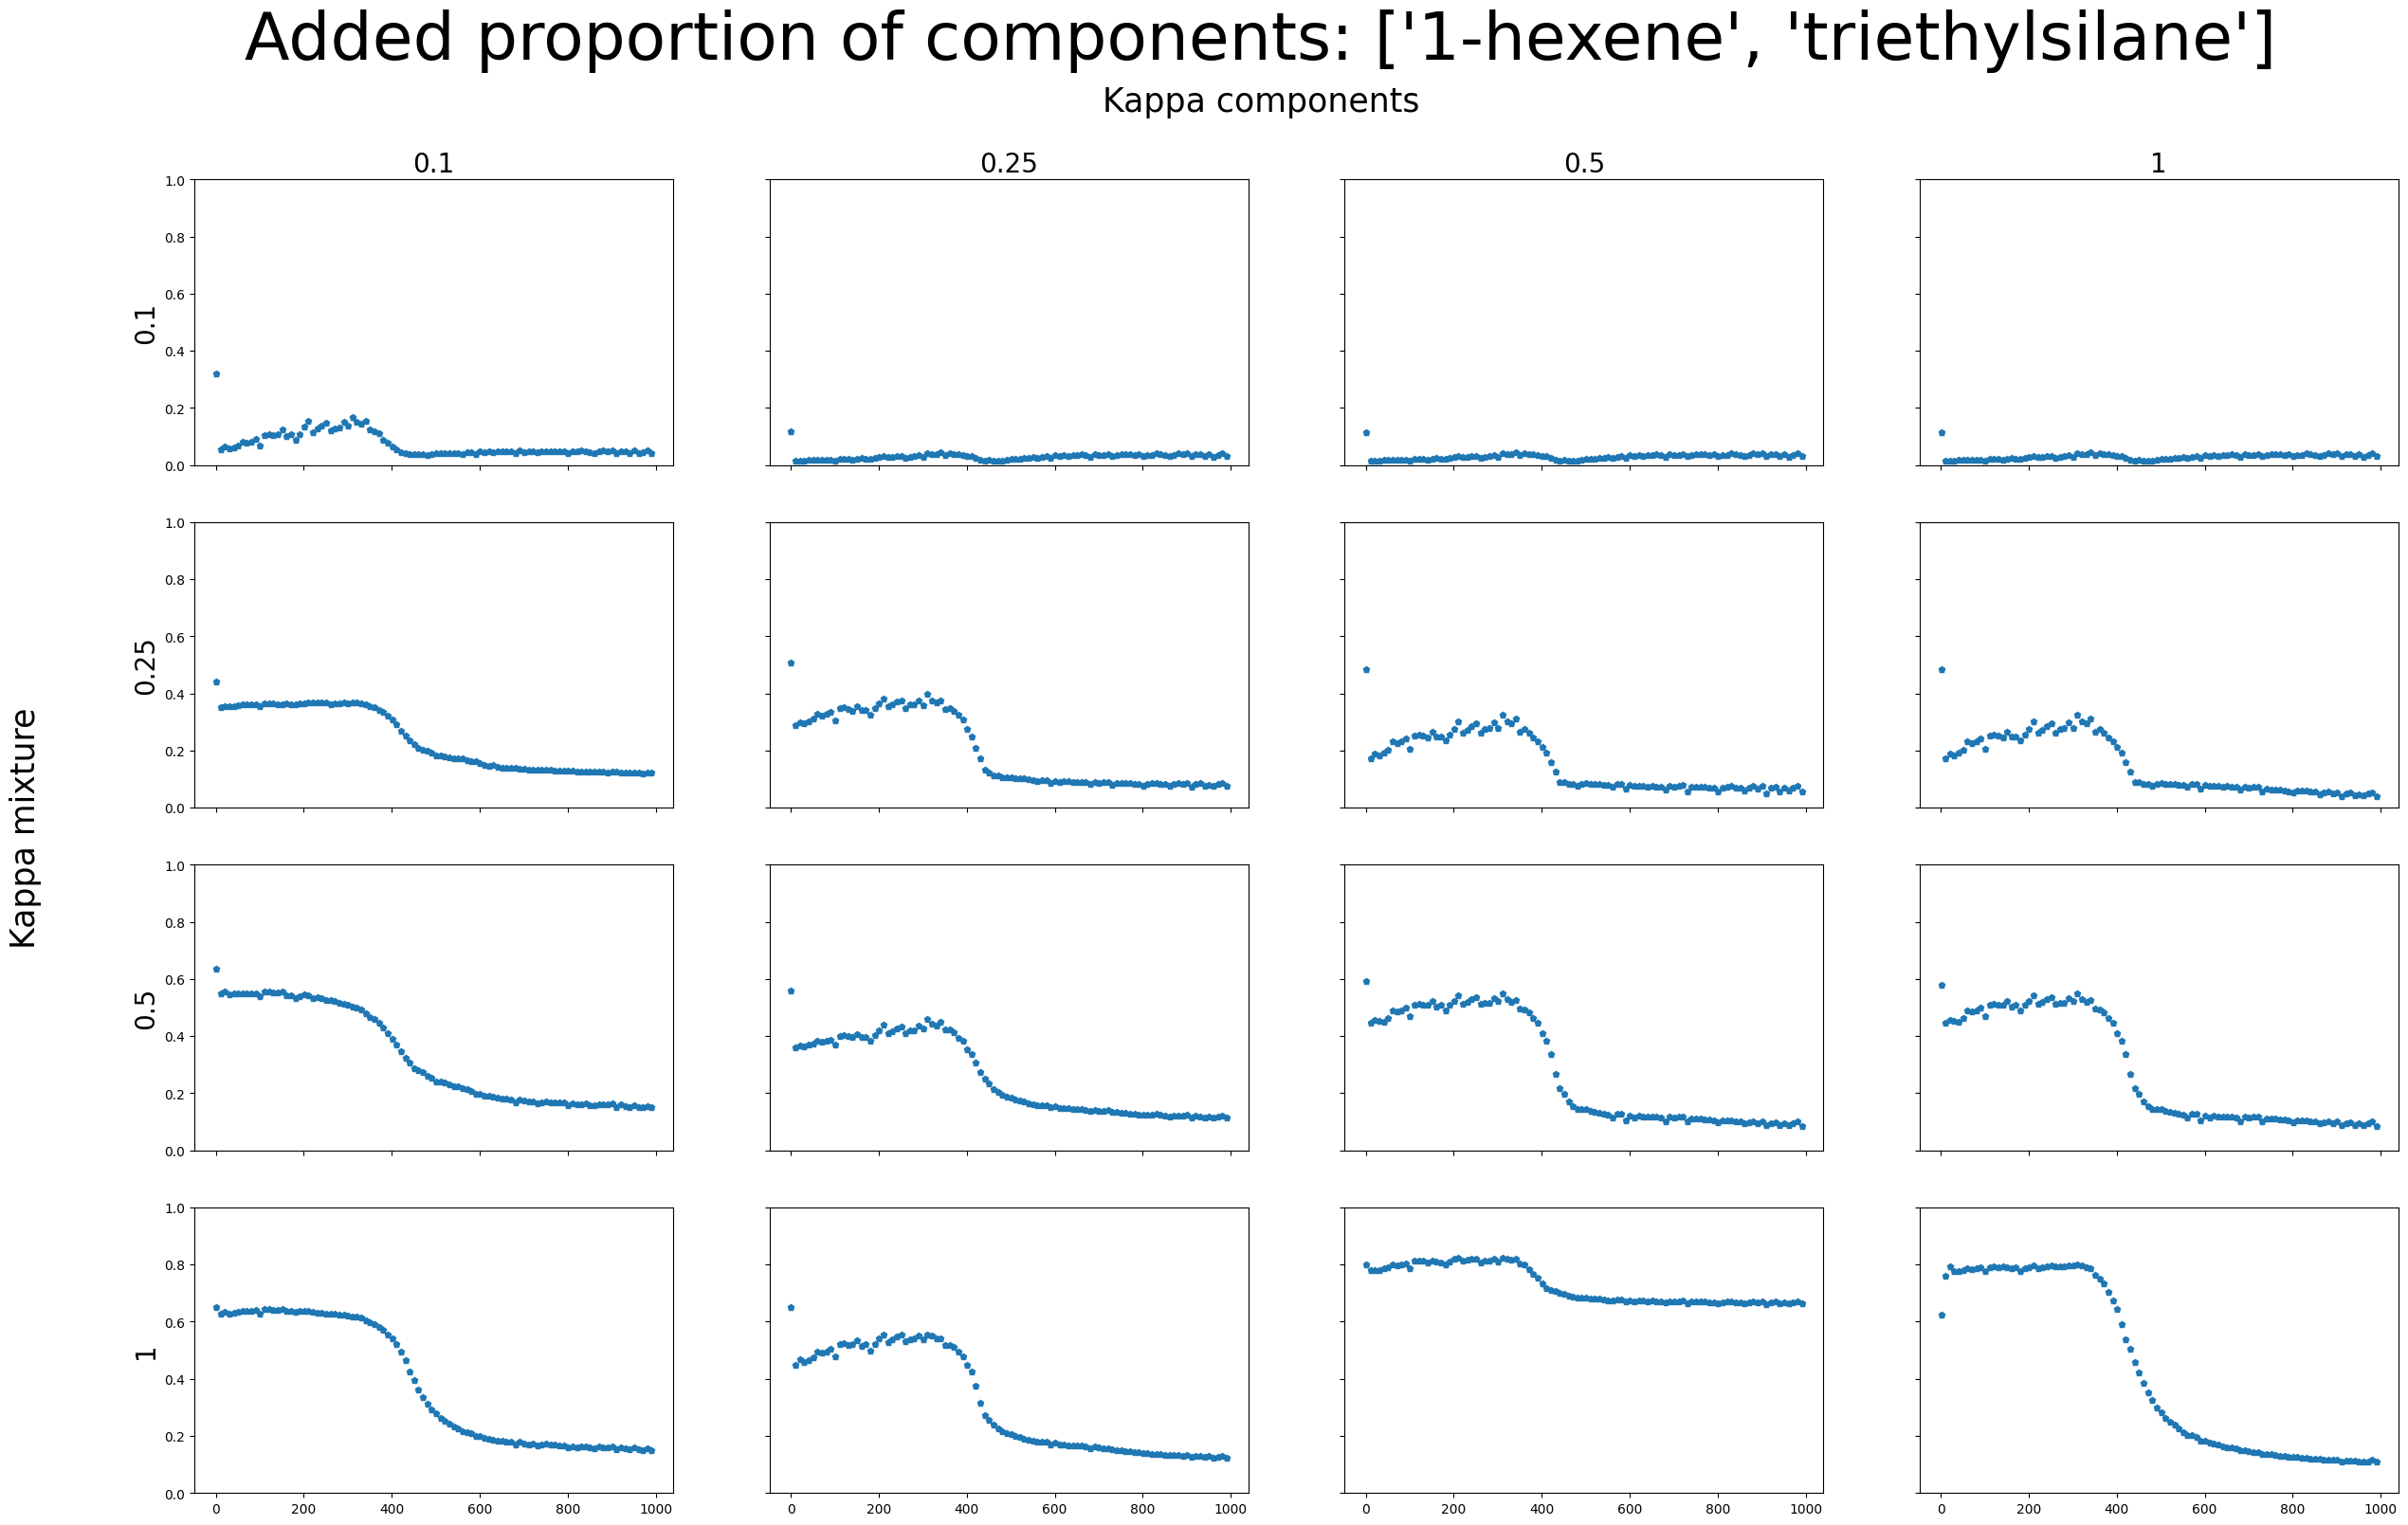

In [21]:
names = [substances_names[experiment_name][nr] for nr in components_numbers]

fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Added proportion of components: ' + str(names), fontsize=50)
fig.set_size_inches(30, 18, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            y = 0
            for nr in components_numbers:
                y = y + results_dict[(kappa, kappa_th)][:, nr]
            axx.plot(time_range[experiment_name], y, 'p', markersize=5)

            if lin_regr:
                t = np.array(time_range[experiment_name])
                t_and_ones = np.vstack([t, np.ones(len(t))]).T
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                axx.plot(time_range[experiment_name], slope*t+intercept, linewidth=2.5)
        except TypeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
fig.savefig(results_paths[experiment_name]+'comparison_for_different_kappas_sum_of_components_' +
                                                   str(names) +'.png')

### Single plot for chosen values of parameters

#### Components separately

In [22]:
best_kappa = 1
best_kappa_th = 1

In [23]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [24]:
component_nr = 0
lin_regr = False

Text(0.5, 0, 'Time')

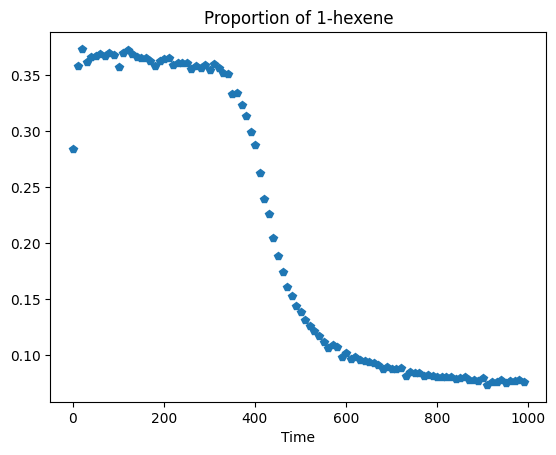

In [25]:
plt.plot(time_range[experiment_name], y[:, component_nr], 'p')
if lin_regr:
    t = np.array(time_range[experiment_name])
    t_and_ones = np.vstack([t, np.ones(len(t))]).T
    slope, intercept = np.linalg.lstsq(t_and_ones, y[:, component_nr])[0]
    plt.plot(time_range[experiment_name], slope*t+intercept)
#plt.title('Proportion of '+substances_names[experiment_name][component_nr])
plt.title('Proportion of ' + substances_names[experiment_name][component_nr])
plt.xlabel('Time')

#### Components on one figure

In [80]:
best_kappa = 1
best_kappa_th = 1

In [81]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

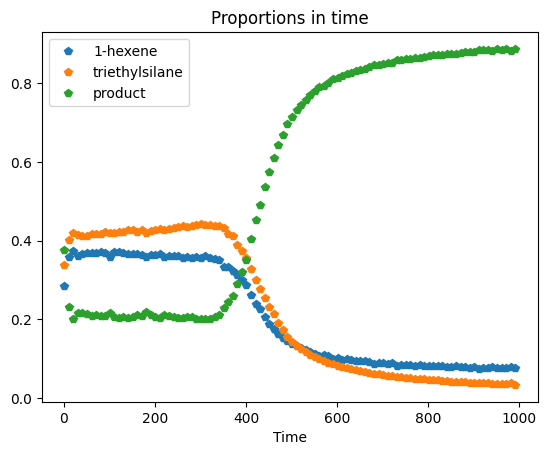

In [82]:
for i in range(y.shape[1]):
    plt.plot(time_range[experiment_name], y[:, i], 'p', label = substances_names[experiment_name][i])
#plt.title('Proportion of '+substances_names[experiment_name][component_nr])
plt.title('Proportions in time')
plt.xlabel('Time')
plt.legend()

#### Components added together

In [95]:
best_kappa = 1
best_kappa_th = 1

In [99]:
component_numbers = [0, 1]
lin_regr = False

In [100]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

Text(0.5, 0, 'Time')

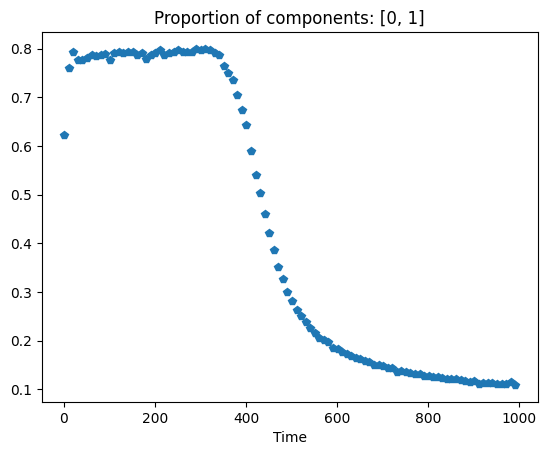

In [101]:
plt.plot(time_range[experiment_name], y[:,component_numbers].sum(1), 'p')
if lin_regr:
    t = np.array(time_range[experiment_name])
    t_and_ones = np.vstack([t, np.ones(len(t))]).T
    slope, intercept = np.linalg.lstsq(t_and_ones, y[:, component_nr])[0]
    plt.plot(time_range[experiment_name], slope*t+intercept)
plt.title('Proportion of components: ' + str(components_numbers))
plt.xlabel('Time')
#plt.ylim(0.5,1)

#### Noise proportion

In [26]:
best_kappa = 1
best_kappa_th = 1

In [27]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

Text(0.5, 1.0, 'Proportion of noise in mixture')

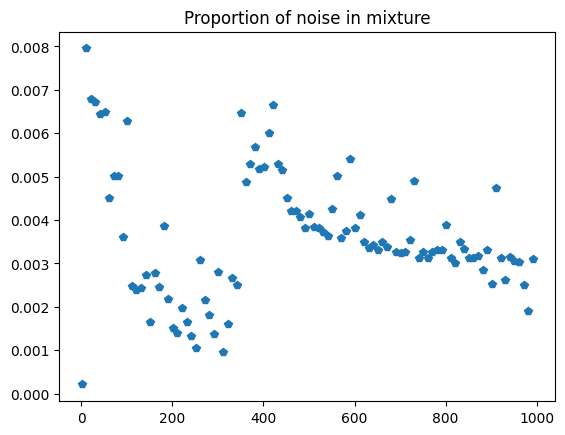

In [28]:
plt.plot(time_range[experiment_name], 1-y.sum(axis=1), 'p')
plt.title('Proportion of noise in mixture')

Another way:

In [108]:
with open(results_paths[experiment_name]+'noise_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

Text(0.5, 1.0, 'Proportion of noise in mixture i.e. proportion of product')

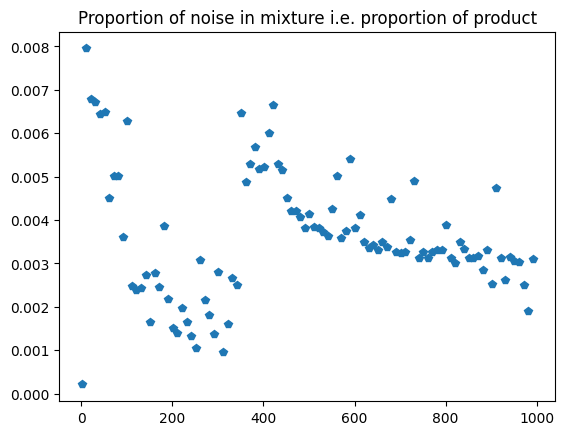

In [109]:
plt.plot(time_range[experiment_name], y.sum(axis=1), 'p')
plt.title('Proportion of noise in mixture i.e. proportion of product')

#### Product and substrates together

In [117]:
best_kappa = 1
best_kappa_th = 1

In [118]:
component_numbers = [0, 1]
product_numbers = [2]
lin_regr = False

In [119]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

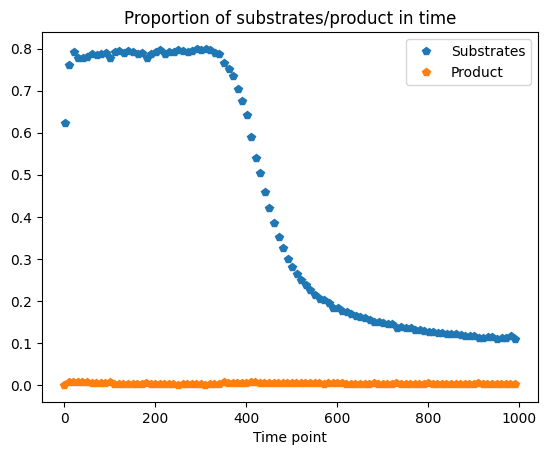

In [124]:
#Version when we don't have spectrum of product (i.e. we assume that noise in mixture is product)

plt.plot(time_range[experiment_name], y[:,component_numbers].sum(1), 'p', label='Substrates')
#plt.ylim(0.5,1)
plt.plot(list(range(y.shape[0]*10))[::10], 1-y.sum(axis=1), 'p', label='Product')
plt.title('Proportion of substrates/product in time')
plt.xlabel('Time point')
plt.legend()
#plt.savefig(results_paths[experiment_name]+'substrates_and_product_together_' + str(best_kappa) +'_'+str(best_kappa_th)+'.png')

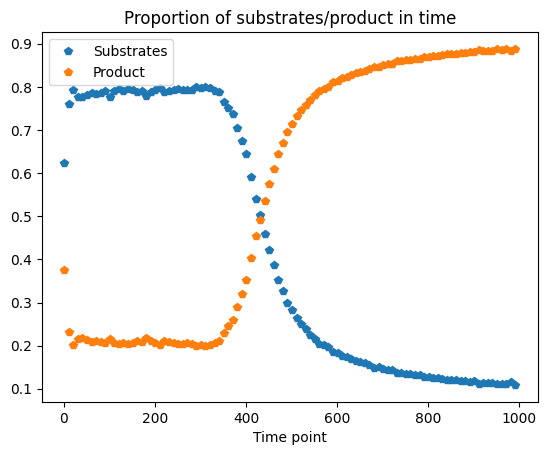

In [132]:
#Version when we have spectrum of product

#Below: version with rescaled time (every 10th measurement was checked)
plt.plot(time_range[experiment_name], y[:,component_numbers].sum(1), 'p', label='Substrates')
#plt.ylim(0.5,1)
plt.plot(time_range[experiment_name], y[:,product_numbers].sum(1), 'p', label='Product')
plt.title('Proportion of substrates/product in time')
plt.xlabel('Time point')
plt.legend()
plt.savefig(results_paths[experiment_name]+'substrates_and_product_together_' + str(best_kappa) +'_'+str(best_kappa_th)+'.png')

### Noise in components

In [29]:
best_kappa = 1
best_kappa_th = 1

In [30]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

Text(0.5, 1.0, 'Proportion of noise in substrates')

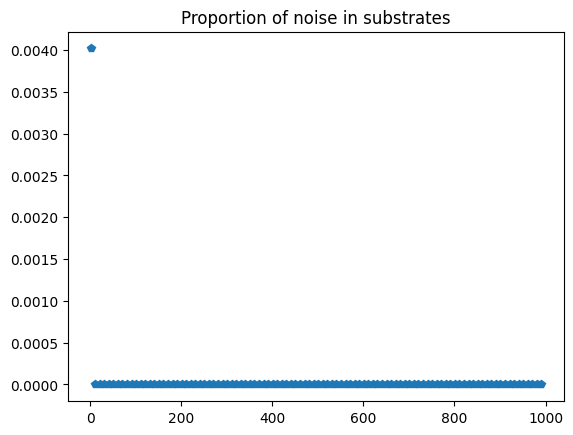

In [31]:
plt.plot(time_range[experiment_name], y, 'p')
plt.title('Proportion of noise in substrates')

### Noise proportion

In [145]:
components_numbers = list(range(len(substances_names[experiment_name])))
lin_regr = True

/tmp/ipykernel_4415/1473175495.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
/tmp/ipykernel_4415/1473175495.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]


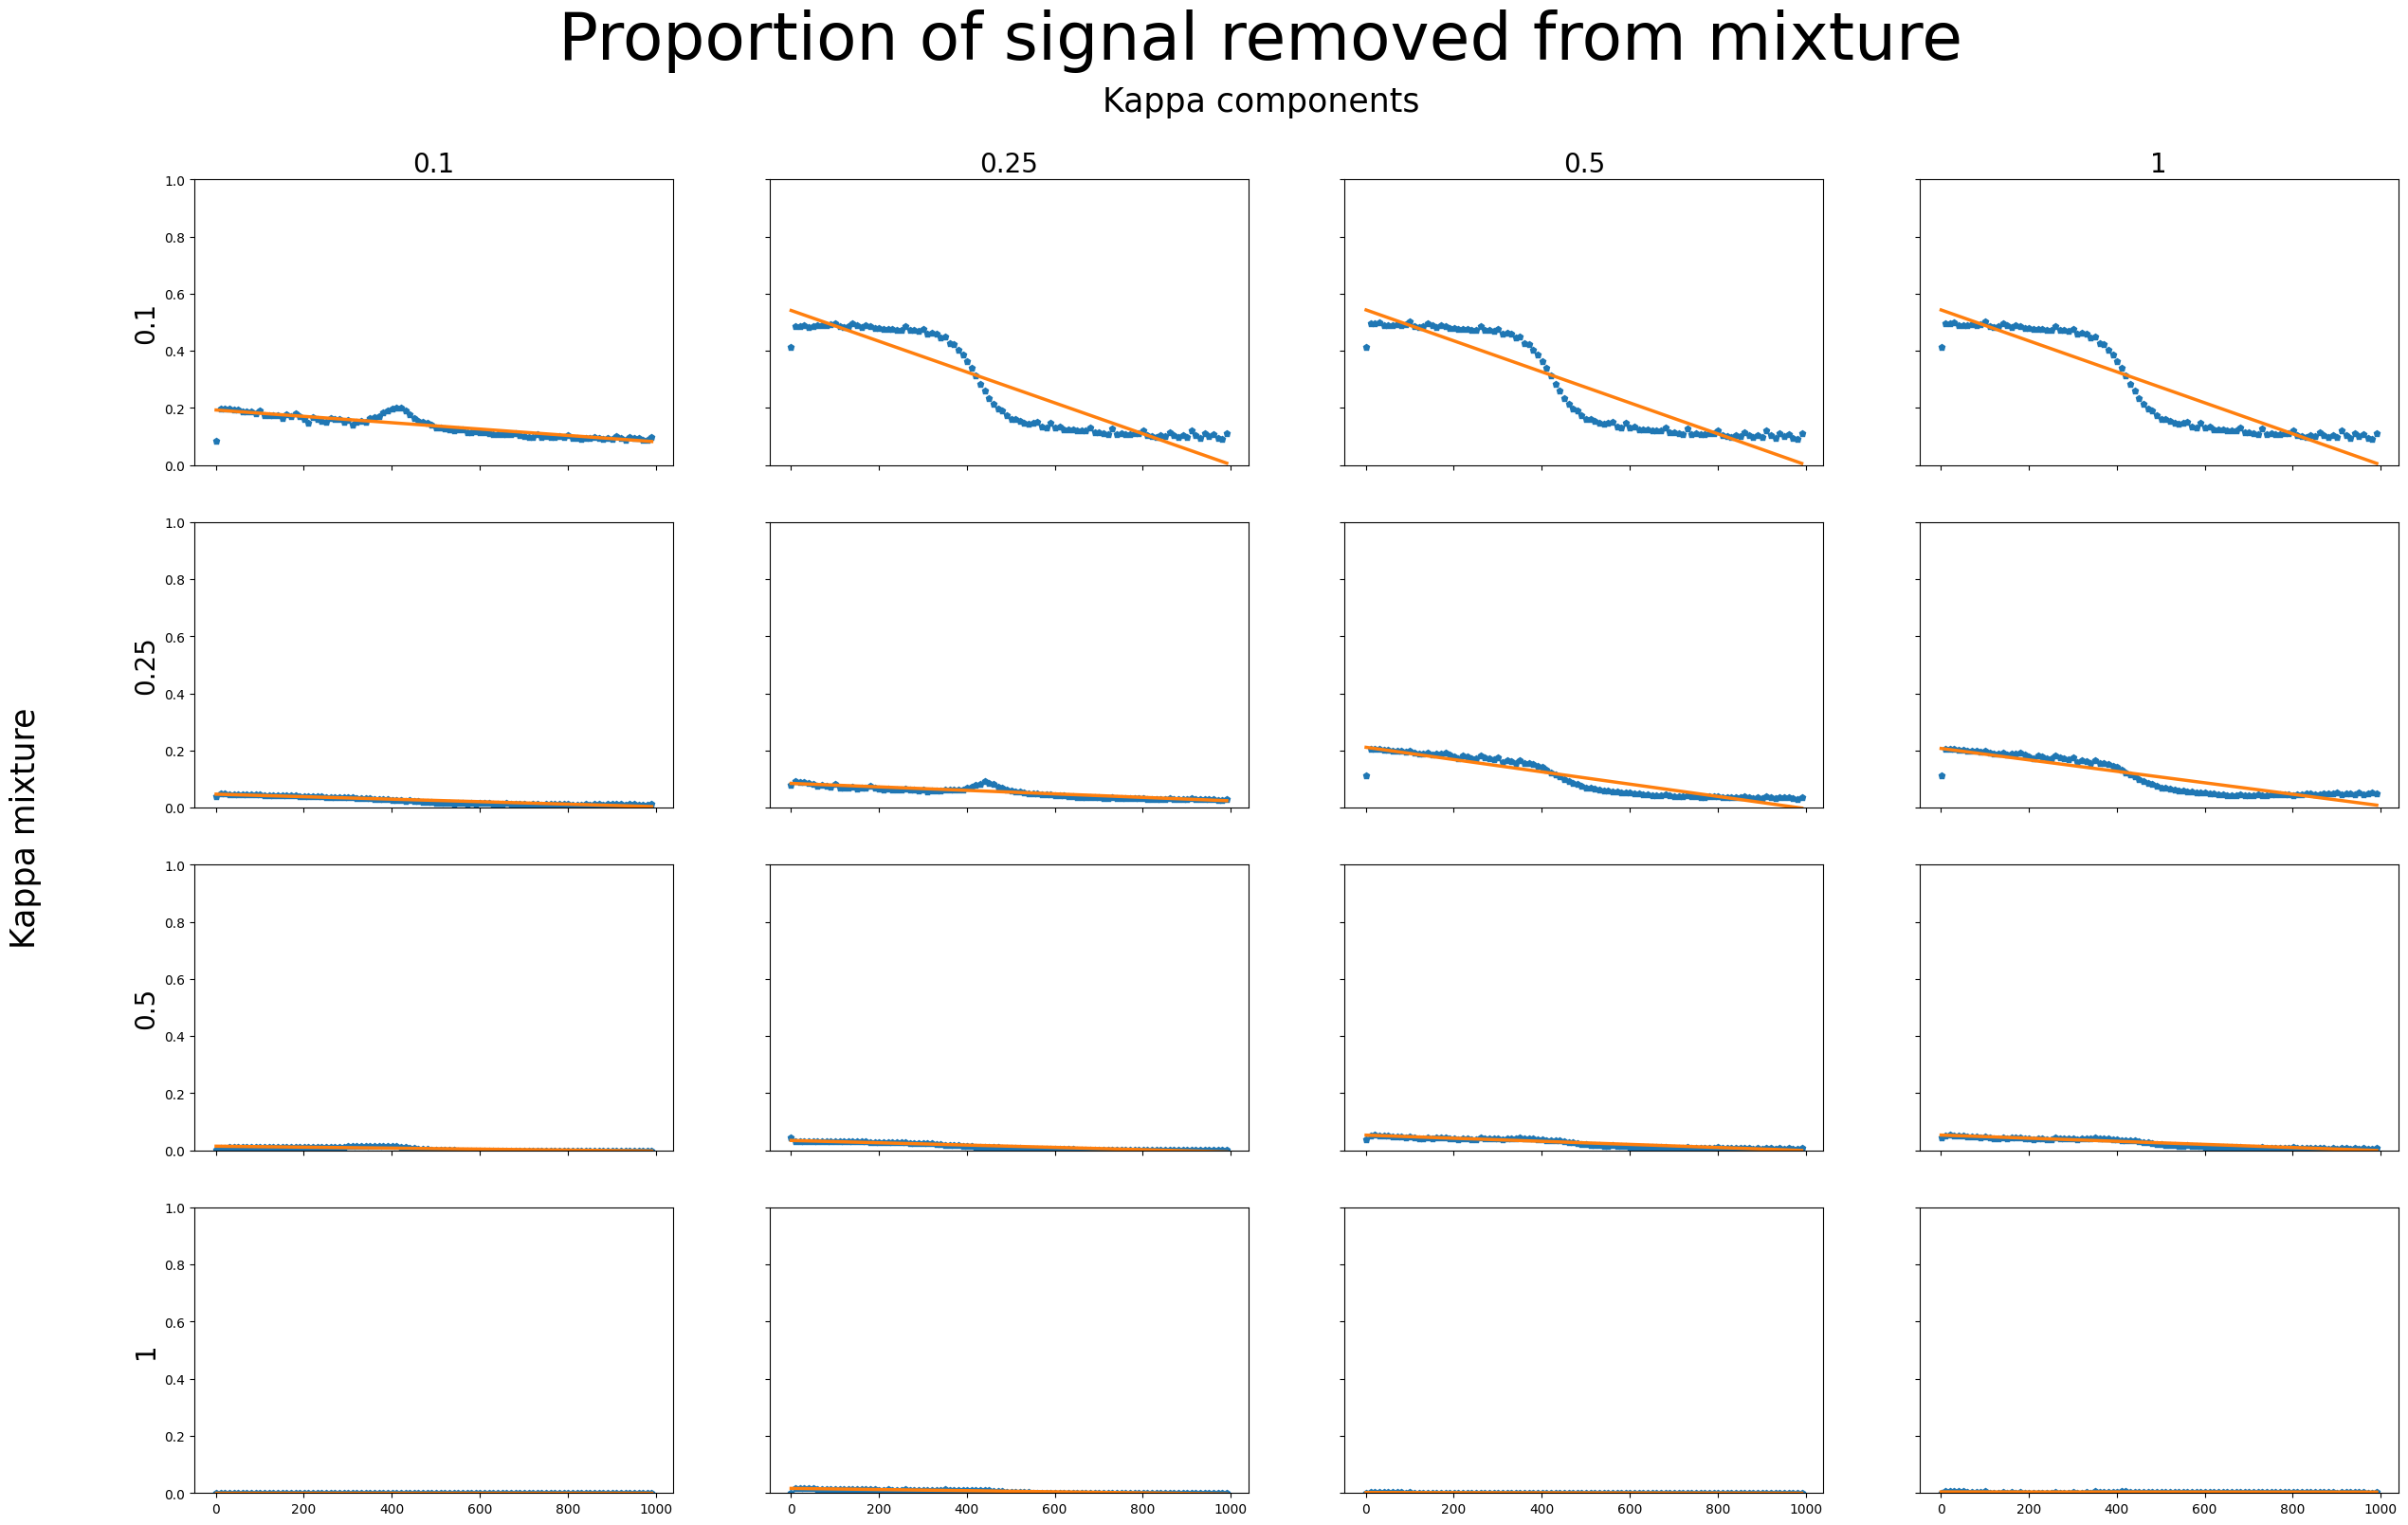

In [146]:
names = [substances_names[experiment_name][nr] for nr in components_numbers]

fig, axs = plt.subplots(len(all_kappas), len(all_kappas_th), sharex='all', sharey='all')
fig.suptitle('Proportion of signal removed from mixture', fontsize=50)
fig.set_size_inches(30, 18, forward=True)

fig.text(0.5, 0.92, 'Kappa components', ha='center', size=25)
fig.text(0.06, 0.5, 'Kappa mixture', va='center', rotation='vertical', size=25)

for i, ax in enumerate(axs):
    kappa = all_kappas[i]
    for j, axx in enumerate(ax):
        kappa_th = all_kappas_th[j]
        try:
            y = 1
            for nr in components_numbers:
                y = y - results_dict[(kappa, kappa_th)][:, nr]
            axx.plot(time_range[experiment_name], y, 'p', markersize=5)
            if lin_regr:
                t = np.array(time_range[experiment_name])
                t_and_ones = np.vstack([t, np.ones(len(t))]).T
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]
                axx.plot(time_range[experiment_name], slope*t+intercept, linewidth=2.5)
        except TypeError:
            axx.plot(0,0)
        
cols = [str(kappa_th) for kappa_th in all_kappas_th]
rows = [str(kappa) for kappa in all_kappas]       

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)
    ax.set_ylim(0,1)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size=20)
#fig.savefig(results_paths[experiment_name]+'proportion_of_removed_signal.png')

### Visualisation of removed signal in mixture

In [148]:
best_kappa = 0.1
best_kappa_th = 0.1

In [149]:
with open(results_paths[experiment_name]+'noise_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [150]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    cha = pickle.load(f)
    cha = np.array(cha)

In [151]:
moment_of_time = 100

In [152]:
noise = y[moment_of_time-1,:]

In [153]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    mixture_time_data = mixture_time_data.iloc[:,:-1]
elif experiment_name == 'PMG 271 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_20th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::20]
    mixture_time_data = pd.concat((ppm, every_20th), axis=1)
elif experiment_name == 'PMG 284 monitoring' or experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [154]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [155]:
mixture_time_data.columns = names

In [156]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    return sp

In [157]:
%matplotlib notebook

In [158]:
mix = load_spectrum(mixture_time_data, moment_of_time)
mix.normalize()

<IPython.core.display.Javascript object>


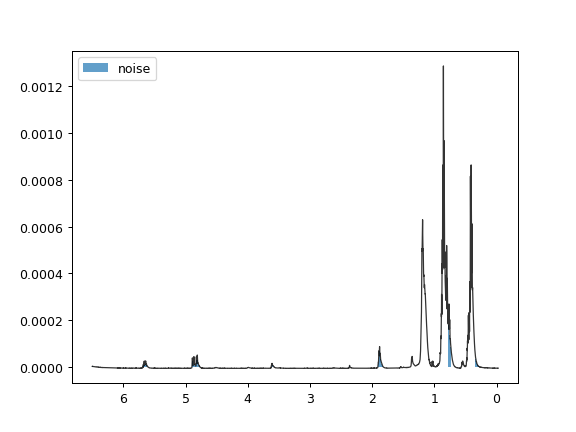

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [159]:
bar_width = np.mean([cha[i]-cha[i-1] for i in range(1, len(cha))])

plt.gca().invert_xaxis()
NMRSpectrum.plot_all([mix], profile=True)
plt.bar(cha, noise, alpha=0.7, label='noise', width=bar_width)
plt.legend()

### Visualisation of removed signal in components

In [160]:
best_kappa = 0.1
best_kappa_th = 0.1

In [161]:
moment_of_time = 60

In [162]:
components_nrs = [0, 1]

In [163]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)
    current_proportions = y[moment_of_time-1, components_nrs]

In [164]:
with open(results_paths[experiment_name]+'noise_in_components_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [165]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(best_kappa)+'_'+str(best_kappa_th)+'.pkl', 'rb') as f:
    cha = pickle.load(f)
    cha = np.array(cha)

In [166]:
noise_in_components = y[moment_of_time-1,:]

In [167]:
reagents = []
for i, path in enumerate(reagents_paths[experiment_name]):
    reag = pd.read_csv(path, sep = reagents_separators[experiment_name])
    sp = NMRSpectrum(confs = list(zip(reag.iloc[:,0], reag.iloc[:,1])))
    sp.normalize()
    reagents.append(sp)

In [168]:
%matplotlib notebook

<IPython.core.display.Javascript object>


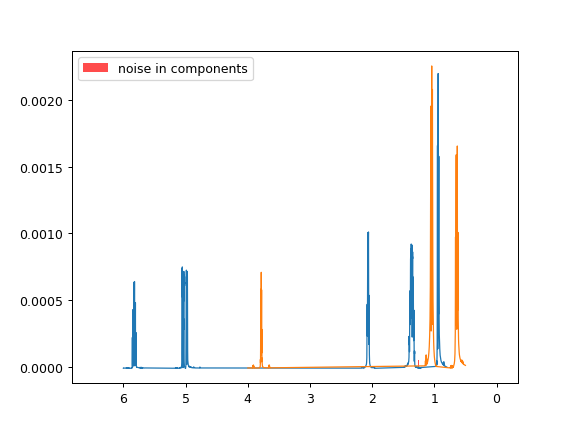

In [169]:
bar_width = np.mean([cha[i]-cha[i-1] for i in range(1, len(cha))])

plt.gca().invert_xaxis()
for i in components_nrs:
    reagents[i].plot(profile=True)
plt.bar(cha, noise_in_components, alpha=0.7, label='noise in components', width=bar_width, color='red')
plt.legend()

<IPython.core.display.Javascript object>


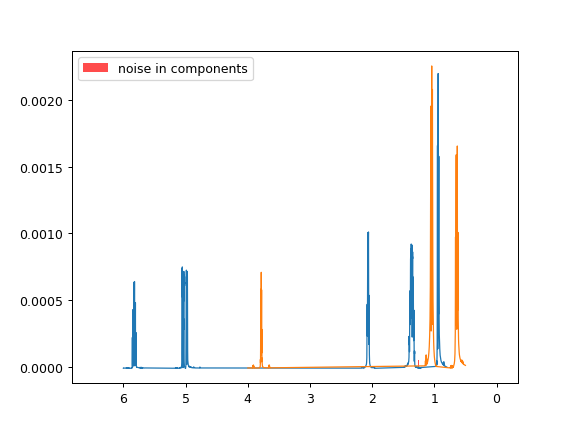

In [170]:
bar_width = np.mean([cha[i]-cha[i-1] for i in range(1, len(cha))])

plt.gca().invert_xaxis()
for i in components_nrs:
    reagents[i].plot(profile=True)
plt.bar(cha, noise_in_components, alpha=0.7, label='noise in components', width=bar_width, color='red')
plt.legend()

### Mixture and components

In [171]:
reagents = []
for i, path in enumerate(reagents_paths[experiment_name]):
    reag = pd.read_csv(path, sep = reagents_separators[experiment_name])
    sp = NMRSpectrum(confs = list(zip(reag.iloc[:,0], reag.iloc[:,1])))
    sp.normalize()
    reagents.append(sp)

In [172]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    mixture_time_data = mixture_time_data.iloc[:,:-1]
elif experiment_name == 'PMG 271 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_20th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::20]
    mixture_time_data = pd.concat((ppm, every_20th), axis=1)
elif experiment_name == 'PMG 284 monitoring' or experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [173]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [174]:
mixture_time_data.columns = names

In [175]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.normalize()
    return sp

<IPython.core.display.Javascript object>


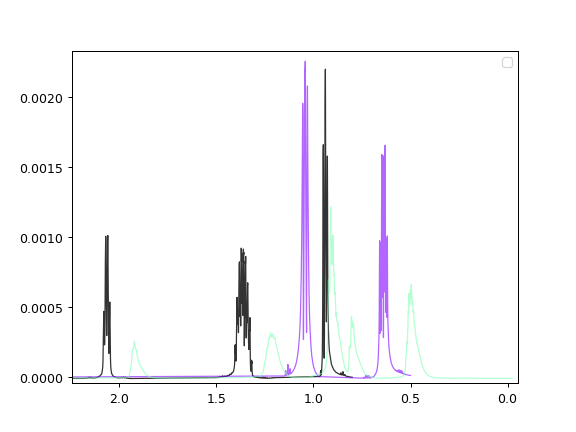

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [176]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all(reagents[:2] + [load_spectrum(mixture_time_data, 10)], profile=True)

<IPython.core.display.Javascript object>


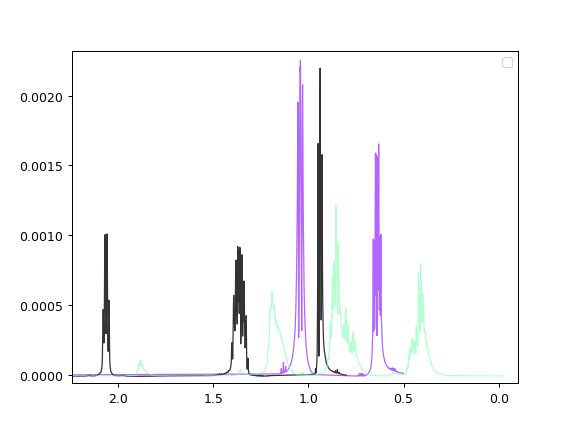

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [177]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all(reagents[:2] + [load_spectrum(mixture_time_data, 60)], profile=True)